In [46]:
import os
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import scipy.io
mat = scipy.io.loadmat('caltech101.mat')

In [72]:
def train_classifier(samples, labels):
    training_samples = samples[labels == 1]
    s_mean_clamped = np.squeeze(np.asarray(np.mean(training_samples, 0)))
    s_cov_clamped = np.cov(training_samples.T)
    m = s_mean_clamped
    C = s_cov_clamped - np.dot(np.asmatrix(s_mean_clamped).T, np.asmatrix(s_mean_clamped))
    delta = np.zeros(s_cov_clamped.shape)
    np.fill_diagonal(delta, 1. / (1. - np.multiply(m, m)))
    w = delta - np.linalg.inv(C)
    theta = np.arctanh(m) - np.dot(w, m)
    F = -0.5 * np.dot(np.dot(m, w), m) - np.dot(theta, m) + 0.5 * np.dot(1 + m, np.log(0.5 * (1 + m))) + 0.5 * np.dot(1 - m, np.log(0.5 * (1 - m)))
    Z = np.exp(-F)
    return w, theta, Z

def calculate_probabilities(samples, w, theta, normalizing_constant):
    return np.exp(-calculate_energy(samples, w, theta)) / normalizing_constant

def calculate_energy(samples, w, theta):
    f = np.dot(samples, np.dot(w, samples.T))
    # Also allow samples consisting of one sample (an array, so f.ndim == 1)
    # Therefore, only take the diagonal in the two dimensional case
    if f.ndim == 2:
        f = np.diagonal(f)
    return np.squeeze(np.asarray(-0.5 * f - np.dot(theta.T, samples.T)))

def generate_samples(s, w, theta, num_burn_in=50, num_samples=500, show_transition_probabilities=False):
    num_neurons = w.shape[0]
    
    # Initialize the matrix of generated samples
    X = np.empty((0, num_neurons))
    
    # Iterate (first generate some samples during the burn-in period and then gather the samples)
    for iteration in range(num_samples):
        for burn_in in range(num_burn_in + 1):
            # Store the original value of s
            s_original = s
            # Calculate the flip probabilities
            p_flip = 0.5 * (1 + np.tanh(np.multiply(-s, np.dot(w, s) + theta)))
            # Calculate transition probabilities
            p_transition = p_flip / float(num_neurons)
            p_stay = 1 - np.sum(p_transition)
            # Flip according to the probability distribution of flipping
            if random.random() <= 1 - p_stay:
                # Pick a random neuron
                neuron = random.randint(1, num_neurons) - 1
                if random.random() <= p_flip[neuron]:
                    s[neuron] *= -1
            # Add the state if the sample is not generated during the burn in period
            if burn_in >= num_burn_in:
                if show_transition_probabilities:
                    print('Transition probabilities for ', s_original,':', p_transition, ' (stay probability: ', p_stay, ')')
                X = np.vstack([X, s.T])
    return X

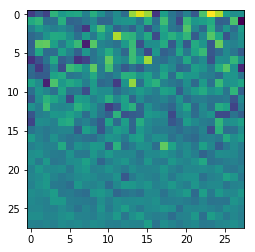

In [168]:
from IPython import display
import time

mask = np.squeeze(np.asarray(mat['train_labels'] == 1))
X = mat['train_data'][mask] * 2. - 1.
noise = np.random.binomial(1, 0.1, X.shape) * -2 + 1
X_noise = np.multiply(X, noise)
#plt.imshow(X_noise[2, :].reshape(28, 28))

w, theta, Z = train_classifier(X_noise, np.squeeze(np.ones((1, X.shape[0]))))
s = np.asmatrix(X[0, :]).T

plt.imshow(theta.reshape(28, 28))
# for i in range(1000):
#     samples = generate_samples(s, w, theta.T, 200, 1)
#     s = np.asmatrix(samples[samples.shape[0] - 1, :]).T
#     plt.imshow(s.reshape(28, 28))
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     time.sleep(0.1)